# Poincare Map

In [1]:
import rebound
import numpy as np
import math
import ctypes

In [5]:
def hyper(sim):
    ps = sim.particles
    dx  = ps[1].x -ps[0].x
    dy  = ps[1].y -ps[0].y
    dvx = ps[1].vx-ps[0].vx
    dvy = ps[1].vy-ps[0].vy
    return dx*dvx + dy*dvy
def mod2pi(x):
    if x>np.pi:
        return mod2pi(x-2.*np.pi)
    if x<-np.pi:
        return mod2pi(x+2.*np.pi)
    return x

In [3]:
N_points_max = 1000
N_points = 0
poincare_map = np.zeros((N_points_max,2))

while N_points <N_points_max:
    print "new sim"
    sim = rebound.Simulation.from_file("resonance.bin")
    sim.status()
    sim.t = 0.
    dt = 0.13
    dt_epsilon = 0.001
    sign = hyper(sim)
    while sim.t<6000. and N_points < N_points_max:
        oldt = sim.t
        olddt = sim.dt
        sim.integrate(oldt+dt)
        nsign = hyper(sim)
        if sign*nsign < 0.:
            leftt = oldt
            rightt = sim.t
            sim.dt = -olddt
            while (rightt-leftt > dt_epsilon):
                midt = (leftt+rightt)/2.
                rebound.clibrebound.reb_integrator_reset(ctypes.byref(sim))
                sim.integrate(midt, exact_finish_time=1)
                msign = hyper(sim)
                if msign*sign > 0.:
                    leftt = midt
                    sim.dt = 0.3*olddt
                else:
                    rightt = midt
                    sim.dt = -0.3*olddt
            o = sim.calculate_orbits()
            if mod2pi(o[0].f)<0.3:
                tp = np.pi*2.
                phi = o[0].l-2.*o[1].l+o[0].omega+o[0].Omega
                #phi = o[1].omega+o[1].Omega-o[0].omega-o[0].Omega
                phid = (tp/o[0].P-2.*tp/o[1].P)/(tp/o[0].P)
                poincare_map[N_points] = [mod2pi(phi),phid]
                N_points += 1
            sim.dt = olddt
            sim.integrate(oldt+dt)
        sign = nsign

new sim
---------------------------------
REBOUND version:     	2.6.0
REBOUND built on:    	Aug 20 2015 11:50:27
Number of particles: 	3
Selected integrator: 	ias15
Simulation time:     	3000.000000
Current timestep:    	0.057506
---------------------------------
<rebound.Particle object, id=-1 m=1.0 x=-0.00218980162848 y=0.000166211121329 z=0.0 vx=-0.000150813689825 vy=-0.00201984196032 vz=0.0>
<rebound.Particle object, id=-1 m=0.001 x=0.791186489895 y=-0.128926119832 z=0.0 vx=0.139002874553 vy=1.19704330966 vz=0.0>
<rebound.Particle object, id=-1 m=0.001 x=1.50552952176 y=-0.0364881317912 z=0.0 vx=0.0118167939681 vy=0.822801565818 vz=0.0>
---------------------------------


3870.62


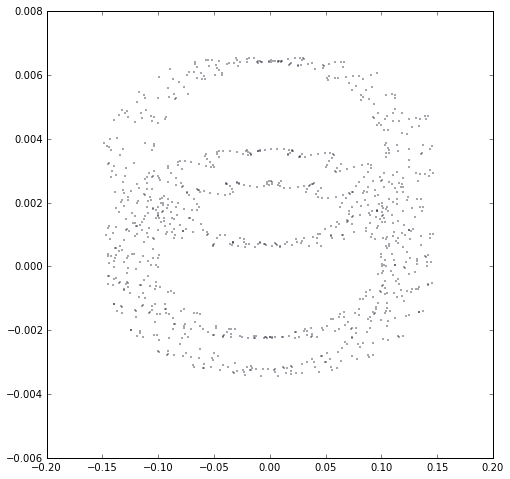

In [4]:
%matplotlib inline
pm_x = poincare_map[:,0]
pm_y = poincare_map[:,1]
if 0:
    pm_maskedx = np.ma.masked_where(pm_x>0., pm_x)
    pm_maskedy = np.ma.masked_where(pm_x>0., pm_y)
else:
    pm_maskedx = pm_x
    pm_maskedy = pm_y

    
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,8))
ax = plt.subplot(111)
ax.scatter(pm_maskedx,pm_maskedy,marker=".",s=1.,alpha=.81)
print sim.t

In [9]:
sim = rebound.Simulation.from_file("resonance.bin")
sim.t = 0.
Nplot = 10000
res = np.zeros((Nplot, 2))
times = np.linspace(0.,18845.19,Nplot)
for i, t in enumerate(times):
    sim.integrate(t,exact_finish_time=1)
    o = sim.calculate_orbits()
    phi = mod2pi(o[1].omega+o[1].Omega-o[0].omega-o[0].Omega)

    phi = mod2pi(o[0].l-2.*o[1].l+o[1].omega+o[1].Omega)
    res[i] = [t,phi]


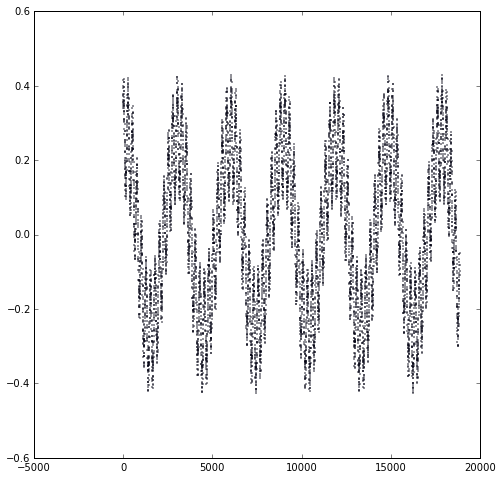

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,8))
ax = plt.subplot(111)
ax.scatter(res[:,0], res[:,1],marker=".",s=1.)
#ax.scatter(res2[:,0], res2[:,1],marker=".",s=1.)

In [14]:
sim = rebound.Simulation()
sim.add(m=1.)
sim.add(m=1e-3,a=1)
sim.add(m=1e-3,a=1.65)
sim.move_to_com()
tau = 50000.
def migrationForce(reb_sim):
    ps[2].ax -= ps[2].vx/tau
    ps[2].ay -= ps[2].vy/tau
    ps[2].az -= ps[2].vz/tau
sim.additional_forces = migrationForce
ps = sim.particles    
Nplot = 1000    
res = np.zeros((Nplot, 2))
res2 = np.zeros((Nplot, 2))
times = np.linspace(0.,3000.,Nplot)
for i, t in enumerate(times):
    sim.integrate(t,exact_finish_time=1)
    o = sim.calculate_orbits()
    res[i] = [t,o[0].a]
    res2[i] = [t,o[1].a]
sim.save("resonance.bin")    